In [ ]:
#!pip install tensorflow
#!pip install opencv-python imutils tqdm

Import all the necessary libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2

# Reading and setup data
import cv2
import imutils
from tqdm import tqdm
import os
from tensorflow.keras.utils import to_categorical

# Loading datasets
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from extractor import process, extract_contour


Define the values of recurrent variables

In [ ]:
SOURCE_DATASET = "/path to my dataset"
PROCESSED_DATASET = "/path to the processed dataset"
IMG_SIZE = 224
TEST_SIZE = 0.2
BATCH_SIZE = 16  
INITIAL_EPOCHS = 15  
FINE_TUNE_EPOCHS = 25  # Fine-tuning epochs
INITIAL_LR = 1e-3
FINE_TUNE_LR = 1e-5

 original image

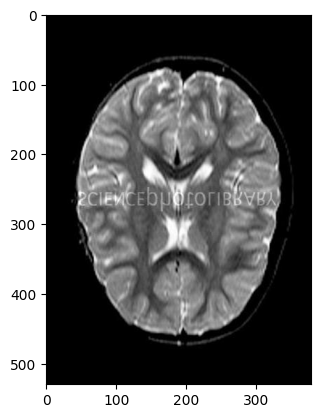

In [ ]:
img = cv2.imread(".\dataset\no\no1496.jpg")
plt.imshow(img)


processed image

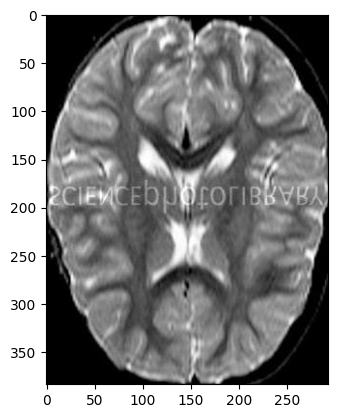

In [ ]:
img=extract_contour(img)
plt.imshow(img)


In [ ]:
#Process the entire dataset
process(SOURCE_DATASET, PROCESSED_DATASET)



Load the dataset

In [ ]:
# Load and preprocess the dataset

def load_data(dataset_path, img_size=224):
    data = []
    labels = []

    for category in ["no", "yes"]:
        folder = os.path.join(dataset_path, category)
        label = 0 if category == "no" else 1

        for file in os.listdir(folder):
            if file.endswith(".jpg"):
                img_path = os.path.join(folder, file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
                data.append(img)
                labels.append(label)

    data = np.array(data, dtype="float32") / 255.0
    labels = to_categorical(np.array(labels), num_classes=2)
    return data, labels

X, y = load_data(PROCESSED_DATASET, 224)
print(f"[INFO] Dataset loaded: {X.shape[0]} images")

[INFO] Dataset loaded: 3000 images


In [ ]:
X[0][0].shape

(224, 3)

Split the dataset

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


In [17]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'

)


In [18]:
val_datagen = ImageDataGenerator()

train_generator = datagen.flow(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

val_generator = val_datagen.flow(
        X_test, y_test,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

Build the CNN model

In [ ]:
def build_improved_cnn_v2(input_shape=(IMG_SIZE, IMG_SIZE, 3)):

    model = Sequential([
        # Block 1
        Conv2D(32, (3,3), padding='same', activation="relu", input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3,3), padding='same', activation="relu"),
        MaxPooling2D(2,2),
        #Dropout(0.2),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3,3), padding='same', activation="relu"),
        BatchNormalization(),
        Conv2D(64, (3,3), padding='same', activation="relu"),
        MaxPooling2D(2,2),
        Dropout(0.3),

        # Block 3
        Conv2D(128, (3,3), padding='same', activation="relu"),
        BatchNormalization(),
        Conv2D(128, (3,3), padding='same', activation="relu"),
        MaxPooling2D(2,2),
        Dropout(0.3),

        # Block 4
        Conv2D(256, (3,3), padding='same', activation="relu"),
        BatchNormalization(),
        Conv2D(256, (3,3), padding='same', activation="relu"),
        MaxPooling2D(2,2),
        Dropout(0.4),

        # Global Average Pooling 
        GlobalAveragePooling2D(),

        # Classification head
        Dense(512, activation="relu", kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        Dense(2, activation="softmax")
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
model2=build_improved_cnn_v2()

We use these callbacks to automatically manage training by preventing overfitting and optimizing learning. Specifically, EarlyStopping stops training when validation performance stops improving, while ReduceLROnPlateau lowers the learning rate when progress stalls, helping the model converge more effectively.

In [ ]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

]

In [ ]:
history3 = model2.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 32s 239ms/step - accuracy: 0.9048 - loss: 0.3878 - val_accuracy: 0.6622 - val_loss: 3.0528 - learning_rate: 5.0000e-04
Epoch 2/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - accuracy: 0.9104 - loss: 0.3745 - val_accuracy: 0.7167 - val_loss: 0.9492 - learning_rate: 5.0000e-04
Epoch 3/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - accuracy: 0.8902 - loss: 0.3953 - val_accuracy: 0.7644 - val_loss: 0.9781 - learning_rate: 5.0000e-04
Epoch 4/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - accuracy: 0.9217 - loss: 0.3237 - val_accuracy: 0.9167 - val_loss: 0.3536 - learning_rate: 5.0000e-04
Epoch 5/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.9227 - loss: 0.2979 - val_accuracy: 0.8467 - val_loss: 0.4513 - learning_rate: 5.0000e-04
Epoch 6/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - accuracy: 0.9363 - loss: 0.2922 - val_accuracy: 0.9467 - val_loss: 0.2913 - learning_rate: 5.0000e-04
Epoch 7/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 21

Fine-tune the model using augmented data instaed of X_train and y_train

In [ ]:
history3 = model2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 57s 332ms/step - accuracy: 0.6304 - loss: 1.3457 - val_accuracy: 0.5000 - val_loss: 1.1387 - learning_rate: 5.0000e-04
Epoch 2/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.6676 - loss: 1.1215 - val_accuracy: 0.5000 - val_loss: 2.6083 - learning_rate: 5.0000e-04
Epoch 3/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 211ms/step - accuracy: 0.7084 - loss: 1.0758 - val_accuracy: 0.5000 - val_loss: 1.2684 - learning_rate: 5.0000e-04
Epoch 4/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - accuracy: 0.7620 - loss: 0.9284 - val_accuracy: 0.5344 - val_loss: 1.2374 - learning_rate: 5.0000e-04
Epoch 5/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - accuracy: 0.7445 - loss: 0.9403 - val_accuracy: 0.6167 - val_loss: 1.0344 - learning_rate: 5.0000e-04
Epoch 6/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.7606 - loss: 0.9000 - val_accuracy: 0.6133 - val_loss: 1.5251 - learning_rate: 5.0000e-04
Epoch 7/25
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 20

Save our model for future use 

In [ ]:
model2.save("brain_tumor_model_v2.h5")

Monitor Training Accuracy and Validation Accuracy to avoid overfitting

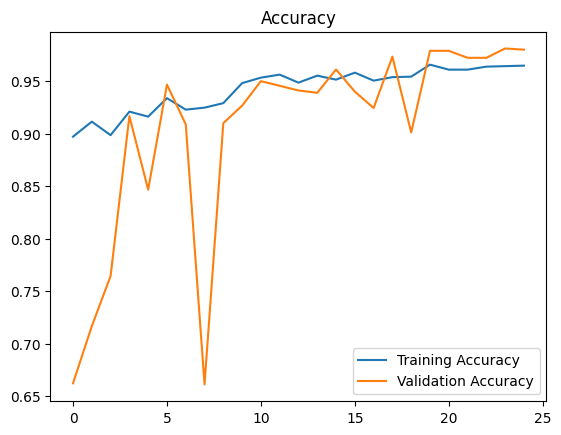

In [ ]:
    # Accuracy
plt.figure()
plt.plot(history3.history["accuracy"], label='Training Accuracy')
plt.plot(history3.history["val_accuracy"], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

We've obtained a validation accuracy of 98% our model can generalize well

In [ ]:
loss, acc = model2.evaluate(val_generator, verbose=1)
print(f"Validation Accuracy: {acc*100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.9772 - loss: 0.1433
Validation Accuracy: 98.00%
Validation Loss: 0.1329


# Example

In [ ]:

def predict_sample(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img=extract_contour(img)
    plt.imshow(img)
    img = np.array(img, dtype="float32") / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    class_idx = np.argmax(pred)
    print(pred)
    print(class_idx)
    return "Yes (Tumor)" if class_idx == 1 else "No (Healthy)"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[4.4547056e-04 9.9955446e-01]]
1
Yes (Tumor)


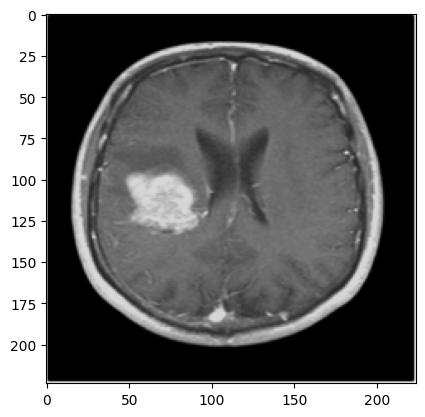

In [ ]:
print(predict_sample("models\\test.png", model2))

# Correct detection with 99.99% accuracy